In [1]:
using DifferentialEquations
using Plots; gr()
include("src/Utils.jl")
using Optim;

# Repressilator

$$
\frac{d}{dt}{p_i} = \alpha_0 + \frac{\alpha}{1 + p_{i - 1}^n} - p_i
$$

Where $i = 1, 2, 3$. The index wraps around so that $1 - 1$ gives 3. A similar model is described in Elowitz and Stanislas 2000. Here I "lumped together" transcription and translation, unlike in Elowitz's paper where the two steps have individual equations.
The unit of time is $1/\beta$ and the unit concentration is $K_M$.

A sufficient condition for the equilibrium $(p_*, p_*, p_*)$ to be stable is

$$
\frac{p_*^{n - 1}}{(1 + p_*^n)^2} < \frac{2}{\alpha n}
$$

Where $p_*$ satisfies

$$
\alpha_0 + \frac{\alpha}{1 + p_*^n} - p_* = 0
$$

## IVP

In [14]:
function repressilator!(dX, X, p, t)
    p1, p2, p3 = X
    ϵ, a, n = p
    
    dX[1] = a*(ϵ + (1 - ϵ)/(1 + p3^n)) - p1
    dX[2] = a*(ϵ + (1 - ϵ)/(1 + p1^n)) - p2
    dX[3] = a*(ϵ + (1 - ϵ)/(1 + p2^n)) - p3
    
    nothing
end;

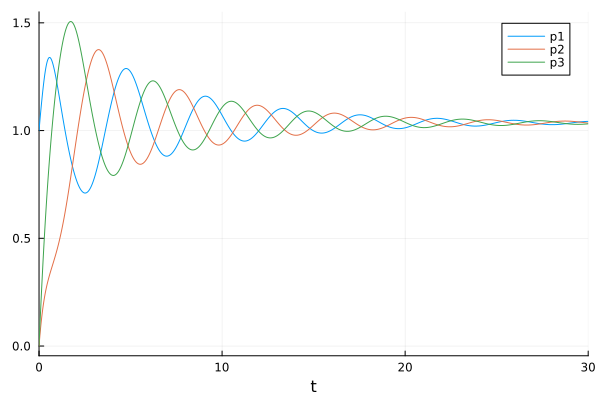

In [20]:
ϵ = 0.1
a = 2
n = 4

p0 = [1, 0, 0]
tspan = (0, 30)

prob = ODEProblem(repressilator!, p0, tspan, [ϵ, a, n])
sol = solve(prob, abstol=1e-8, reltol=1e-8)

plot(sol, labels=reshape(["p1", "p2", "p3"], 1, :))

## Find equilibrium

In [4]:
symmetric_rhs(p, a0, a, n) = a0 + a/(1 + p^n) - p

a0 = 0
a = 10
n = 4

p0 = [1.0]

res = optimize(x -> symmetric_rhs(first(x), a0, a, n)^2, p0, LBFGS(); autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     4.032854e-27

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.01e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.61e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.98e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.90e+15 ≰ 0.0e+00
    |g(x)|                 = 5.57e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    34
    ∇f(x) calls:   34


In [5]:
hopf_ev(pss, a0, a, n) = -2*(1 + pss^n)^2 + a*n*pss^(n - 1)

hopf_ev (generic function with 1 method)

## Find Hopf points

In [6]:
a0 = 0.6
n = 4

function hopf_ev_from_para(_a0, _a, _n)
    #p0 = [10.0]
    res = optimize(x -> symmetric_rhs(x, _a0, _a, _n)^2, 0.0, 20.0)
    pss = first(Optim.minimizer(res))
    return hopf_ev(pss, _a0, _a, _n)
end

res = optimize(x -> hopf_ev_from_para(a0, x, n)^2, 0.0, 100.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 100.000000]
 * Minimizer: 5.414082e+00
 * Minimum: 6.740168e-17
 * Iterations: 17
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 18

In [15]:
hopf_ev_from_para(0.6, 5, 4)

-1.4007798308415147

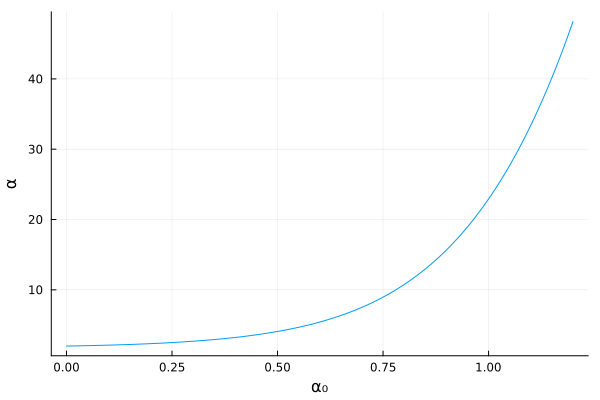

In [7]:
a0_vec = 0:0.01:1.2
hopf_a_vec = zeros(length(a0_vec))
n = 4

for (i, a0) in enumerate(a0_vec)
    res = optimize(x -> hopf_ev_from_para(a0, x, n)^2, 0.0, 200.0)
    hopf_a_vec[i] = Optim.minimizer(res)
end

plot(a0_vec, hopf_a_vec, legend=false)
xlabel!("α₀")
ylabel!("α")

## Numerically find the period

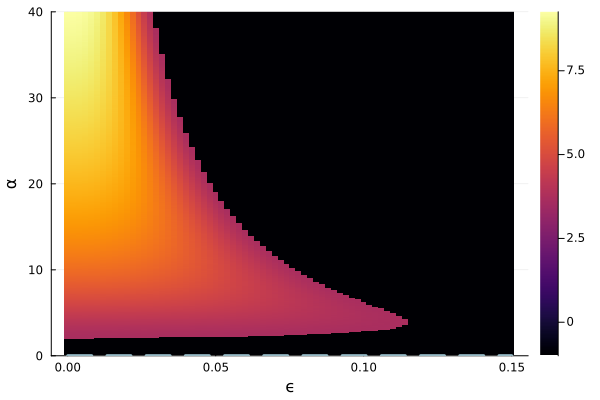

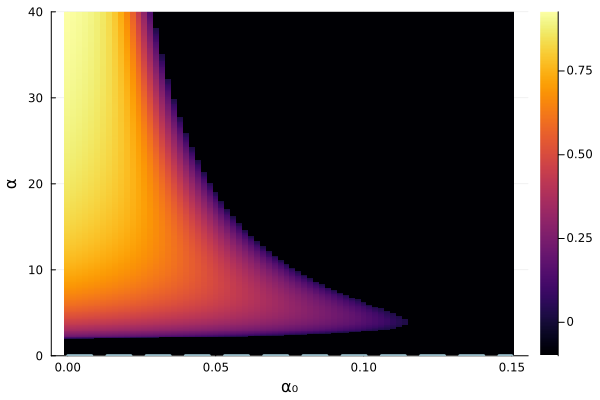

In [25]:
ϵ_vec = 0.0:2e-3:0.15
a_vec = 0.1:0.1:40
n = 4

# find period numerically
per_mat = zeros(length(ϵ_vec), length(a_vec))
amp_mat = zeros(length(ϵ_vec), length(a_vec))
    
p0 = [1, 0, 0]

for (i, ϵ) in enumerate(ϵ_vec)
    for (j, a) in enumerate(a_vec)
        converge, amplitude, per, phase = 
        attracted_to(repressilator!, p0, 50, [ϵ, a, n], burnin=25, conv_tol=1e-2, amp_cutoff=2e-2)
        per_mat[i, j] = per
        amp_mat[i, j] = amplitude == -1 ? -0.1 : amplitude
    end
end

hopf_a_vec = zeros(length(ϵ_vec))

# # find Hopf point from closed form
# for (i, ϵ) in enumerate(ϵ_vec)
#     res = optimize(x -> hopf_ev_from_para(ϵ, x, n)^2, 0.0, 200.0)
#     hopf_a_vec[i] = Optim.minimizer(res)
# end
       
p = heatmap(ϵ_vec, a_vec, transpose(per_mat))
plot!(p, ϵ_vec, hopf_a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!(p, "ϵ")
ylabel!(p, "α")
ylims!(p, 0, 40)
display(p)

heatmap(ϵ_vec, a_vec, transpose(amp_mat))
plot!(ϵ_vec, hopf_a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("α₀")
ylabel!("α")
ylims!(0, 40)

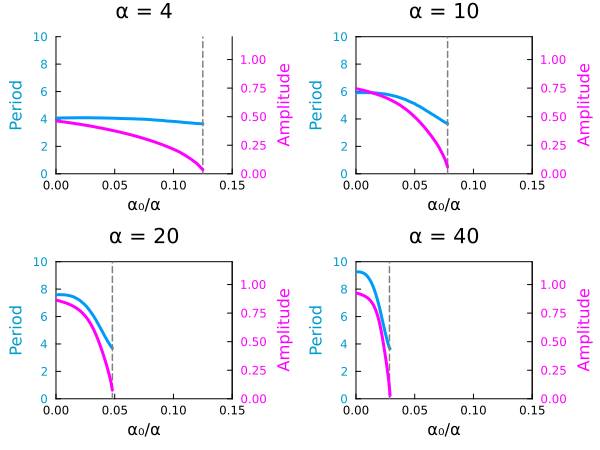

In [83]:
# intersect at fixed alpha
fixed_a_vec = [4.0, 10.0, 20.0, 40.0]

fil_id = []
j = 1
for (i, a) in enumerate(a_vec)
    if abs(fixed_a_vec[j] - a) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_a_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

fil_amp_mat = amp_mat[:, fil_id]
fil_amp_mat = (x -> x == -1 ? NaN : x).(fil_amp_mat)

rel_a0_mat = a0_vec*transpose(1 ./ fixed_a_vec)

# pull out Hopf points
hopf_id = zeros(Int64, length(fixed_a_vec))
for (i, fa) in enumerate(fixed_a_vec)
    min_diff = 1e5
    min_id = -1
    for (j, a) in enumerate(hopf_a_vec)
        diff = abs(a - fa)
        if diff < min_diff
            min_id = j
            min_diff = diff
        end
    end
    hopf_id[i] = min_id
end

# plot
p = plot(rel_a0_mat, fil_per_mat; layout=4, legend=false, 
    title=(x -> "α = $(Int(x))").(transpose(fixed_a_vec)), size=(600, 450), linewidth=3,
    framestyle=:box, grid=false, framewidth=2, margin=2Plots.mm, 
    yguidefontcolor="deepskyblue3", ytickfontcolor="deepskyblue3")
ylims!(p, 0, 10)
xlims!(0, 0.15)
xlabel!(p, "α₀/α")
ylabel!(p, "Period")

for i in 1:4
    plot!(twinx(p[i]), rel_a0_mat[:, i], fil_amp_mat[:, i]; legend=false, 
    linewidth=3, color="magenta", ylims=(0, 1.2), xlims=(0, 0.15), 
    tickfontcolor="magenta", yguidefontcolor="magenta", ylabel="Amplitude")
    # hopf point
    vline!(p[i], [a0_vec[hopf_id[i]]]/fixed_a_vec[i], linestyle=:dash, color=:gray, linewidth=1.5)
end

display(p)

### Try a different $n$

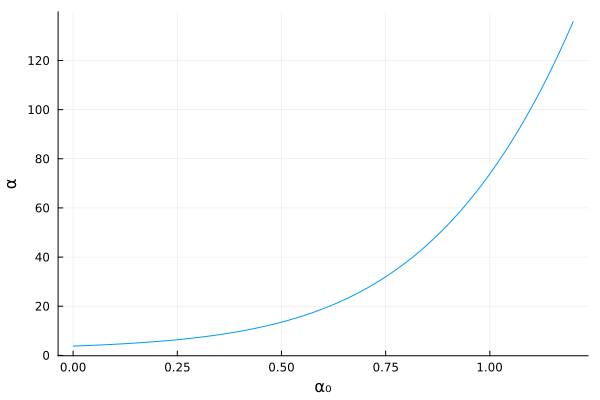

In [11]:
a0_vec = 0:0.01:1.2
hopf_a_vec = zeros(length(a0_vec))
n = 3

for (i, a0) in enumerate(a0_vec)
    res = optimize(x -> hopf_ev_from_para(a0, x, n)^2, 0.0, 200.0)
    hopf_a_vec[i] = Optim.minimizer(res)
end

plot(a0_vec, hopf_a_vec, legend=false)
xlabel!("α₀")
ylabel!("α")

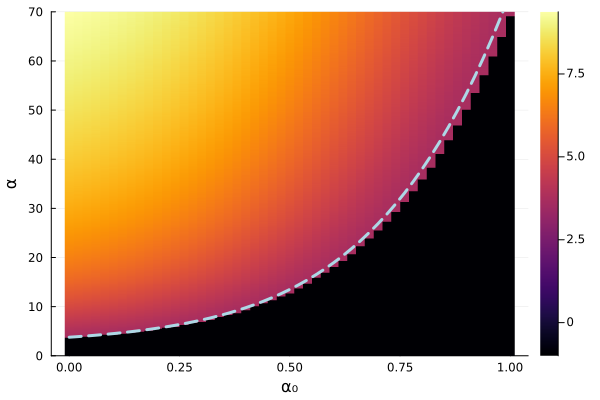

In [12]:
a0_vec = 0:0.02:1.0
a_vec = 0:0.2:70
n = 3

# find period numerically
per_mat = zeros(length(a0_vec), length(a_vec))
    
p0 = [1, 0, 0]

for (i, a0) in enumerate(a0_vec)
    for (j, a) in enumerate(a_vec)
        converge, amplitude, per, phase = 
        attracted_to(repressilator!, p0, 50, [a0, a, n], burnin=25, conv_tol=1e-2, amp_cutoff=3e-2)
        per_mat[i, j] = per
    end
end

hopf_a_vec = zeros(length(a0_vec))

# find Hopf point from closed form
for (i, a0) in enumerate(a0_vec)
    res = optimize(x -> hopf_ev_from_para(a0, x, n)^2, 0.0, 100.0)
    hopf_a_vec[i] = Optim.minimizer(res)
end
       
heatmap(a0_vec, a_vec, transpose(per_mat))
plot!(a0_vec, hopf_a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("α₀")
ylabel!("α")
ylims!(0, 70)

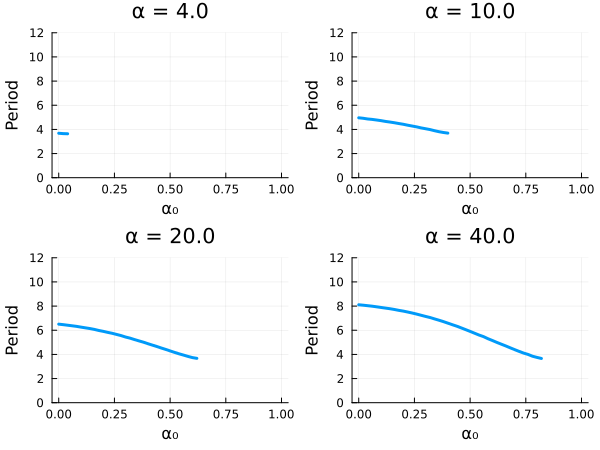

In [13]:
# intersect at fixed alpha
fixed_a_vec = [4.0, 10.0, 20.0, 40.0]

fil_id = []
j = 1
for (i, a) in enumerate(a_vec)
    if abs(fixed_a_vec[j] - a) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_a_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

# plot
plot(a0_vec, fil_per_mat; layout=4, legend=false, 
    title=(x -> "α = $x").(transpose(fixed_a_vec)), size=(600, 450), linewidth=3)
ylims!(0, 12)
xlabel!("α₀")
ylabel!("Period")

## Try a different secondary param

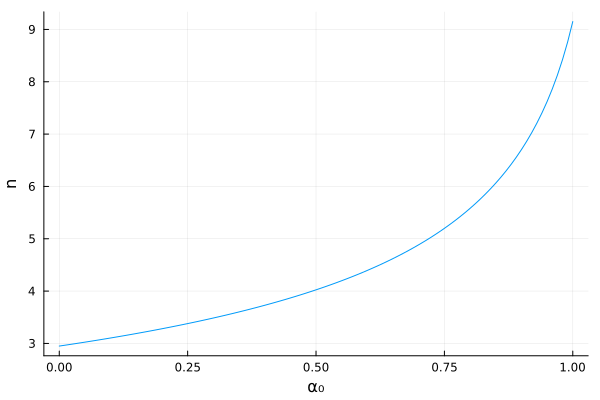

In [14]:
a0_vec = 0:0.01:1.0
hopf_n_vec = zeros(length(a0_vec))
a = 4

for (i, a0) in enumerate(a0_vec)
    res = optimize(x -> hopf_ev_from_para(a0, a, x)^2, 0.0, 20.0)
    hopf_n_vec[i] = Optim.minimizer(res)
end

plot(a0_vec, hopf_n_vec, legend=false)
xlabel!("α₀")
ylabel!("n")

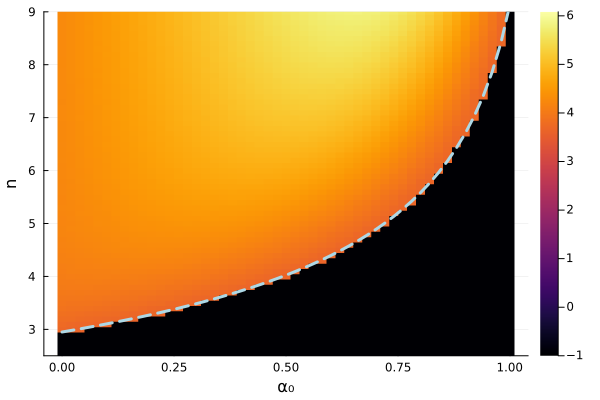

In [15]:
a0_vec = 0:0.02:1.0
a = 4
n_vec = 2:0.1:10

# find period numerically
per_mat = zeros(length(a0_vec), length(n_vec))
    
p0 = [1, 0, 0]

for (i, a0) in enumerate(a0_vec)
    for (j, n) in enumerate(n_vec)
        converge, amplitude, per, phase = 
        attracted_to(repressilator!, p0, 50, [a0, a, n], burnin=25, conv_tol=1e-2, amp_cutoff=3e-2)
        per_mat[i, j] = per
    end
end

hopf_n_vec = zeros(length(a0_vec))

# find Hopf point from closed form
for (i, a0) in enumerate(a0_vec)
    res = optimize(x -> hopf_ev_from_para(a0, a, x)^2, 0.0, 15.0)
    hopf_n_vec[i] = Optim.minimizer(res)
end
       
heatmap(a0_vec, n_vec, transpose(per_mat))
plot!(a0_vec, hopf_n_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("α₀")
ylabel!("n")
ylims!(2.5, 9)

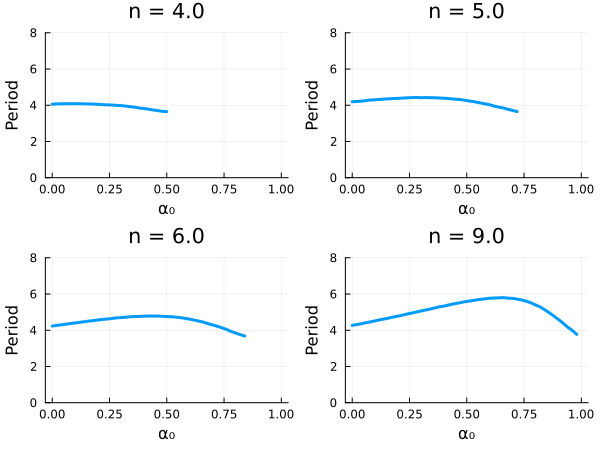

In [16]:
# intersect at fixed alpha
fixed_n_vec = [4.0, 5.0, 6.0, 9.0]

fil_id = []
j = 1
for (i, n) in enumerate(n_vec)
    if abs(fixed_n_vec[j] - n) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_n_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

# plot
plot(a0_vec, fil_per_mat; layout=4, legend=false, 
    title=(x -> "n = $x").(transpose(fixed_n_vec)), size=(600, 450), linewidth=3)
ylims!(0, 8)
xlabel!("α₀")
ylabel!("Period")